<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400102182
Name = 'Parsa'
Last_Name = 'Norouzinezhad'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [2]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

## Importing Libraries

In [3]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [4]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:10<00:00, 2561337.79it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 243531.08it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4264977.35it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19040808.63it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [5]:
num_classes = len(train_set.classes)
print(num_classes)

image , _ = train_set[0]
ch, h, w = image.shape
input_dimension = ch * h * w
print(input_dimension)

10
784


In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

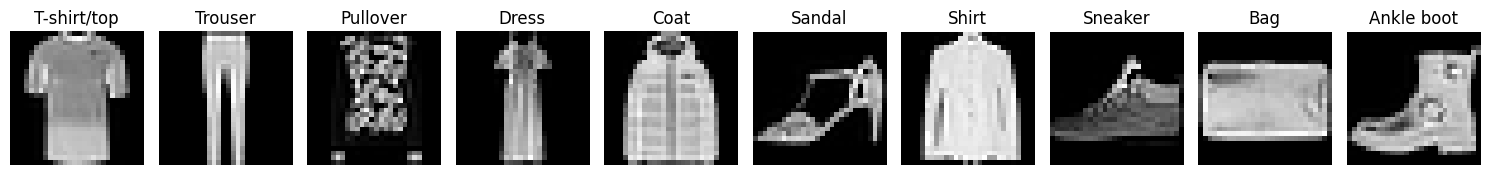

In [7]:
class_names = train_set.classes
images_per_class = {}
for images, labels in train_loader:
    for i in range(len(labels)):
        label = labels[i].item()
        if label not in images_per_class:
            images_per_class[label] = images[i]
        if len(images_per_class) == len(class_names):
            break
    if len(images_per_class) == len(class_names):
        break

fig, axes = plt.subplots(1, len(class_names), figsize=(15, 2))
for label, image in images_per_class.items():
    ax = axes[label]
    image = image.squeeze()
    ax.imshow(image, cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()


## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:
layers = [
    (input_dimension, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [10]:
def affine_forward(x, w, b):
    x_reshaped = x.view(x.size(0), -1)
    return x_reshaped @ w + b

def relu(x):
    return torch.maximum(x, torch.tensor(0.0, device=x.device))


Function `model` returns output of the whole model for the input `x` using the parameters:

In [11]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)


    out = x
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        out = torch.matmul(out, w) + b
        if i < num_layers - 1:
            out = torch.maximum(out, torch.tensor(0.0, device=out.device))
    return out

Implementing cross entropy loss:

In [18]:
def cross_entropy_loss(scores, y):
    n = len(y)
    exp_scores = torch.exp(scores - torch.max(scores, dim=1, keepdim=True).values)
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    nll = -torch.log(probs[range(n), y])
    loss = torch.mean(nll)
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [13]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    for param in parameters.values():
        param.data -= learning_rate * param.grad
    for param in parameters.values():
        if param.grad is not None:
            param.grad.zero_()

**Training** functions:

In [19]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    correct = np.sum(y_pred == y_true)
    total = len(y_true)
    acc = correct / total
    return acc
def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)

    Y = []
    Y_pred = []


    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()
        loss.backward()
        sgd_optimizer(parameters, learning_rate)

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)


    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [15]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [22]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_loss, test_acc = validate(test_loader, epoch, "test")
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.show()
    ## plot the accuracy history of training and test sets
    ## FILL HERE
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.show()

Accuracy of train set: 0.8765
Accuracy of test set: 0.8821166666666667
Accuracy of train set: 0.8778166666666667
Accuracy of test set: 0.8826333333333334
Accuracy of train set: 0.8781
Accuracy of test set: 0.882
Accuracy of train set: 0.8813
Accuracy of test set: 0.8826333333333334
Accuracy of train set: 0.8824
Accuracy of test set: 0.8822833333333333
Accuracy of train set: 0.883
Accuracy of test set: 0.8873666666666666
Accuracy of train set: 0.885
Accuracy of test set: 0.8723666666666666
Accuracy of train set: 0.8868
Accuracy of test set: 0.8844166666666666
Accuracy of train set: 0.8875666666666666
Accuracy of test set: 0.8911333333333333
Accuracy of train set: 0.88835
Accuracy of test set: 0.8961333333333333


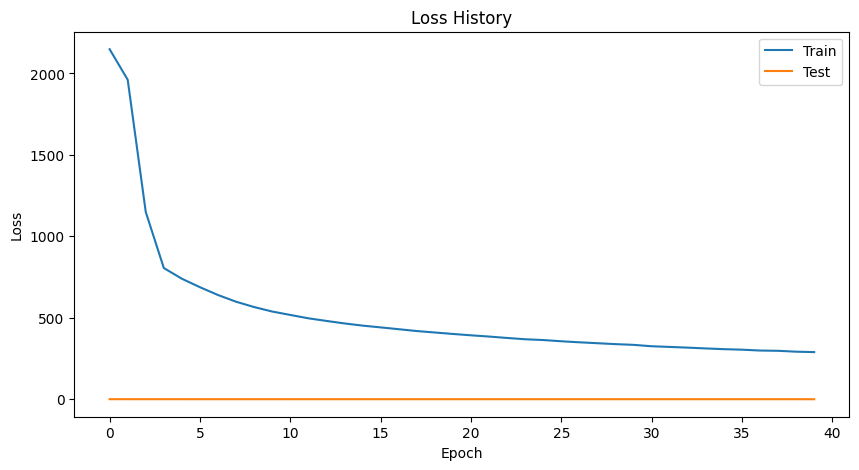

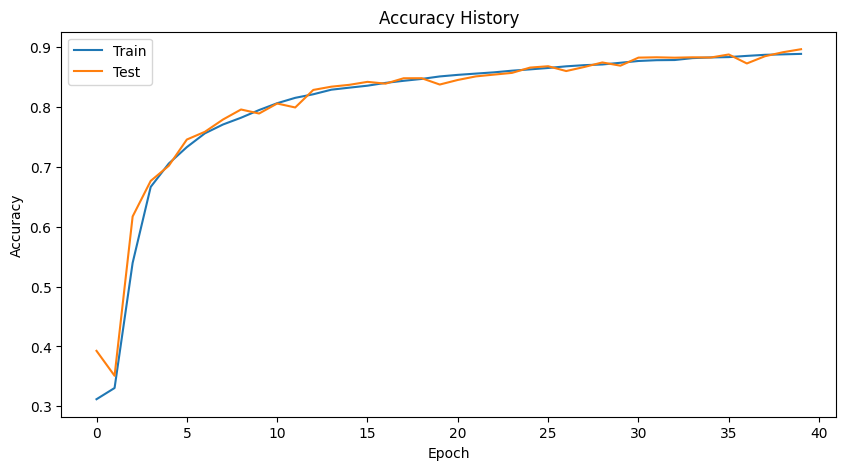

In [25]:
train_model([train_loader, test_loader], num_epochs=10, learning_rate=0.005)

In [26]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8961333333333333


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.


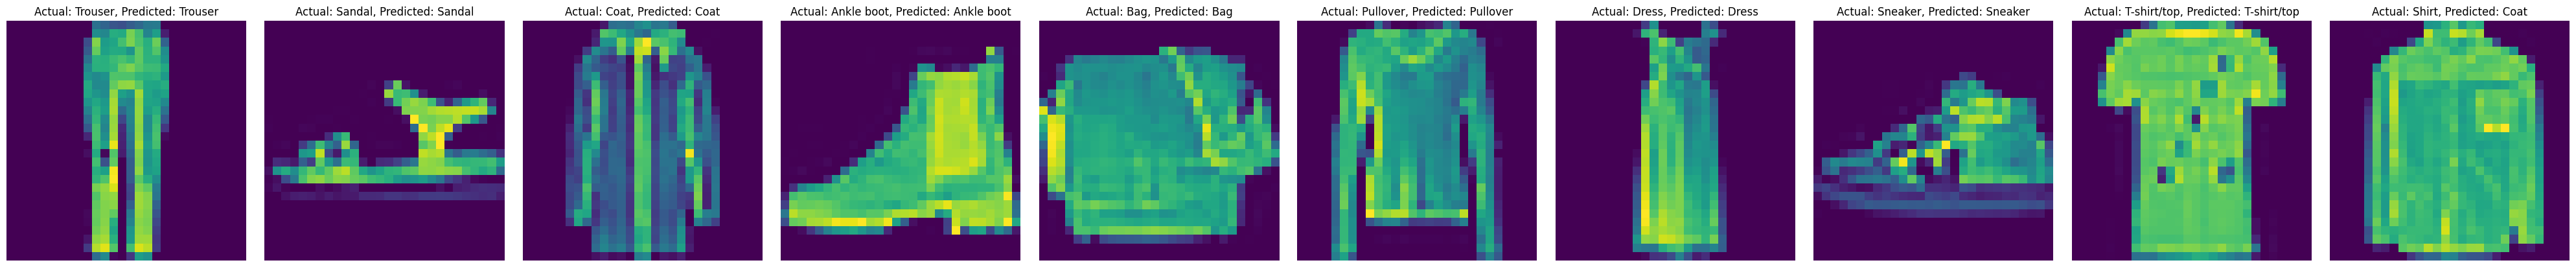

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_class_images(model, test_loader, class_names):
    """
    Visualizes one image from each class along with both the actual and predicted labels.

    Args:
    - model: Trained model.
    - test_loader: DataLoader for the test dataset.
    - class_names (list): List of class names.

    Returns:
    - None
    """
    # Set the model to evaluation mode
    #model_instance = model()

    # Initialize a dictionary to store one image from each class
    class_images = {}

    # Iterate over the test dataset to find one image from each class
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images,parameters).argmax(dim=1)

        for image, label, pred in zip(images, labels, preds):
            class_idx = label.item()
            if class_idx not in class_images:
                class_images[class_idx] = (image.cpu(), label.item(), pred.item())
                break

    # Plot the images
    num_classes = len(class_images)
    fig, axes = plt.subplots(1, num_classes, figsize=(4*num_classes, 4))

    for i, class_idx in enumerate(class_images.keys()):
        image, true_label, pred_label = class_images[class_idx]
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convert from tensor to numpy array and transpose dimensions
        ax.set_title(f'Actual: {class_names[true_label]}, Predicted: {class_names[pred_label]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'model' is the trained model, 'test_loader' is the DataLoader for the test dataset,
# and 'class_names' is a list containing the names of the classes
visualize_class_images(model, test_loader, class_names)
